# Librerias

In [1]:
# from oficial python
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch
from matplotlib import cm
import matplotlib as mpl
from qutip import basis
import time
from sklearn.model_selection import train_test_split
import os
from qutip import sigmaz, sigmax, sigmay, mesolve


# own modules:
from dll.spin_procesor_modificated import Quantum_Spin_Proces
from dll.main_fun import make_IRIS_v2
from dll.main_fun import pulse_x_cos, pulse_x, pulse_z, pulse_x_with_noise
from dll. baseline_dru_v2 import Modelo_DRU
from dll.models import qcircuit_1_qubit_mixed
from dll.cost_functions import fidelity_cost
from dll.gate_procesor_modificated import CompositeGateProcessor
from dll.plot_expectation_values import plot_excharges, plot_expect

# Funciones

In [9]:
color_palette = [
    "#0f5492", "#cc6e0b", "#206821", "#a01d1d",
    "#704c92", "#63403a", "#9f5f91", "#666666",
    "#8c9520", "#118c9f", "#94b5d1", "#d18e56",
    "#75b871", "#d18f8d", "#a28bbf", "#a07d76"]

In [10]:
def plot_measure_continuous(ax, t, probability_i, i, arrow, tf_noise = False):
    if tf_noise == True:
        label_str = rf"$\left| \{arrow} \right\rangle_{{noisy}}$"
        if isinstance(arrow, list):
            arrow_str = ' '.join(arrow)  # Concatenar los elementos de la lista separados por un espacio
            label_str = rf"$\left| {arrow_str} \right\rangle_{{noisy}}$"
    else:
        label_str = rf"$\left| \{arrow} \right\rangle$"
        if isinstance(arrow, list):
            arrow_str = ' '.join(arrow)  # Concatenar los elementos de la lista separados por un espacio
            label_str = rf"$\left| {arrow_str} \right\rangle$"
    ax.plot(t*1e9, probability_i, c=color_palette[i],
            alpha=0.7, label = label_str)

In [11]:
def plot_measure_continuous_RZ(ax, t, probability_i, i, arrow, tf_noise = False):
    if tf_noise == True:
        label_str = rf"$\left| {arrow} \right\rangle_{{noisy}}$"
        if isinstance(arrow, list):
            arrow_str = ' '.join(arrow)  # Concatenar los elementos de la lista separados por un espacio
            label_str = rf"$left| {arrow_str} \right\rangle_{{noisy}}$"
    else:
        label_str = rf"$\left| {arrow} \right\rangle$"
        if isinstance(arrow, list):
            arrow_str = ' '.join(arrow)  # Concatenar los elementos de la lista separados por un espacio
            label_str = rf"$\left| {arrow_str} \right\rangle$"
    ax.plot(t*1e9, probability_i, c=color_palette[i],
            alpha=0.7, label = label_str)

In [12]:
def plot_measure_scatter(ax, t, probability_i, i, arrow, N=100, random_seed=None, tf_noise = False):
    #if random_seed is not None:
    #    np.random.seed(random_seed)

    if tf_noise == True:
        label_str = rf"$\left| \{arrow} \right\rangle_{{noisy}}$"
    else:
        label_str = rf"$\left| \{arrow} \right\rangle$"

    # Convertir probability_i a un array numpy si no lo es
    probability_i = np.array(probability_i)

    # Seleccionar N índices aleatorios de los datos
    random_indices = np.random.choice(len(t), size=N, replace=False).astype(int)
    selected_t = t[random_indices]
    selected_probability_i = probability_i[random_indices]

    # Crear lista de 16 tipos de marcadores distintos
    marker_types = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', '>', '<', 'h', 'd', '|', '_', '+', '.']

    ax.scatter(selected_t*1e9, selected_probability_i, c=color_palette[i],
                alpha=0.7, label = label_str, s=10,
                  marker=marker_types[i])

In [13]:
def calculate_T1(T2, T2start):
    T1 = (1/2)*((T2*T2start)/(T2start - T2))
    return T1

In [14]:
def measure_compuse_states(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_0 = []
    Measure_1 = []
    for i in range(n_states_time):

        states_i = procesor.states_in_time[i]
        get_statest = [state.full() for state in states_i]

        state_0 = list_states_overlap[0]
        probability_0 = [np.abs(state_0 @ state)[0][0]**2 for state in get_statest]
        Measure_0.extend(probability_0)

        state_1 = list_states_overlap[1]
        probability_1 = [np.abs(state_1 @ state)[0][0]**2 for state in get_statest]
        Measure_1.extend(probability_1)

    time = np.linspace(0, procesor.global_time, len(Measure_1))
    return time, Measure_0, Measure_1

#### 2 qubits

In [15]:
def measure_quantum_states(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_i = [[] for _ in range(len(list_states_overlap))]

    for i in range(n_states_time):
        for j, state_measure in enumerate(list_states_overlap):

            states_i = procesor.states_in_time[i]
            get_statest = [state.full() for state in states_i]
            _,nc = get_statest[0].shape
            if nc == 1:
                probability_i = [np.abs(state_measure @ state)[0][0]**2 for state in get_statest]
            else:
                probability_i = [np.abs((state_measure @ state @ state_measure.T)[0][0]) for state in get_statest]
            Measure_i[j].extend(probability_i)

    time = np.linspace(0, procesor.global_time, len(Measure_i[0]))
    return time, Measure_i

# I. Pruebas Modelo

## I.I. Qubit - tiempo

### I.I.I. Rotation $R_x$

#### Real Hamiltonian

Hamiltoniano real sin aproximacion RWA.

Frecuencia = 1999999.9999999995 [Hz]


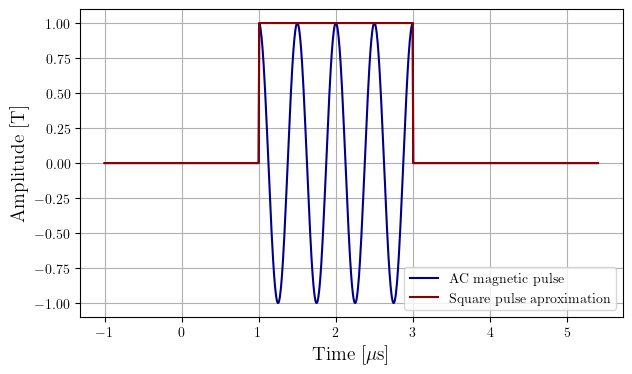

In [17]:
# Pulso cosenoidal B1:
ti = 1e-6
tf = 3e-6
delt_t = tf - ti
nf = 4
ω_x = (2*np.pi*nf)/delt_t
print(f"Frecuencia = {ω_x /(2*np.pi)} [Hz]")
# Ejemplo de uso
tiempo = np.linspace(-1e-6, tf*1.80, 1000)
args_ejemplo = {"t_init": ti, "t_final": tf, "w": ω_x}

pulso_cos = pulse_x_cos(tiempo, args_ejemplo)
pulso = pulse_x(tiempo, args_ejemplo)

fig, ax = plt.subplots(figsize=(7, 4))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(tiempo*1e6 , pulso_cos, label = 'AC magnetic pulse', color='darkblue')
plt.plot(tiempo*1e6 , pulso, label = 'Square pulse aproximation', color='darkred')
plt.grid()
plt.legend()
plt.title("")
plt.ylabel("Amplitude [T]", fontsize = 14)
plt.xlabel(r"Time [$\mu$s]", fontsize = 14)
path_to_save_img = os.path.join("results_of_test","test_2","pulse_compare.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

Ahora se simula el hamiltoniano sin aproximación.

In [18]:
# Parametros para fijar frecuencia de larmor
h = 1
# factor giromagnetico:
gir = 1.760e11
# angulo deseado:
alpha = np.pi/2
# Campo homogeneo:
B0 = -10e-3
print(f"B0 = {B0} [T]")
# Para girar univamente en el eje x se necesita hacer que
ω_z = gir*B0
ω_x = gir*B0
# numero de ciclos:
nf = 4

print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (np.abs(alpha)*nf)/np.abs(ω_x)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = (alpha * 2)/(gir * delt_t)
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

B0 = -0.01 [T]
ω_x = -1760000000.0 [rad/s]
f_x = -280112699.8417358 [hz]
tiempo = 3.5699916518065832e-09 [s]
B1 = 0.005 [T]


In [19]:
# Simulacion sin RWA:
up = basis(2,0)
H0 = (h/2)*(ω_z)*sigmaz()
H1 = (h)*O_x*sigmax()
H = [H0,[H1, pulse_x_cos]]
args = {"t_init": 0, "t_final": delt_t, "w":ω_x}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)
output_time = mesolve(H, up, tlist, c_ops, e_ops, args)

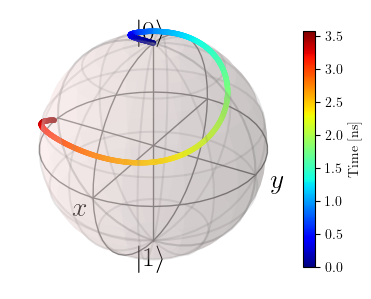

In [20]:
## create Bloch sphere instance ##
fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
b = Bloch()
b.axes = ax1
b.fig = fig
## normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(0, delt_t*1e9)
colors = cm.jet(nrm(tlist)*1e9)
## add data points from expectation values ##
b.add_points([output_time.expect[0],output_time.expect[1],output_time.expect[2]],'m')
## customize sphere properties ##
b.point_color=list(colors)
b.point_marker=['o']
b.point_size=[8]
b.view=[-9,11]
b.zlpos=[1.1,-1.2]
b.zlabel=[r"$\left| 0 \right\rangle $", r"$\left| 1 \right\rangle$"]
## plot sphere ##
## Add color bar ##
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=nrm)
sm.set_array([])  # You need to set a dummy array for the right scaling
cbar = plt.colorbar(sm, ax = ax1, orientation='vertical', shrink=0.5)
cbar.set_label('Time [ns]')
b.render()
path_to_save_img = os.path.join("results_of_test","test_2","Rx_without_RWA.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

In [21]:
print(output_time.expect[0][-1])
print(output_time.expect[1][-1])
print(output_time.expect[2][-1])

0.06328604932825804
-0.9979695842065338
0.007182266986072883


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


-9.480424775831061e-07
-0.9999999999993798
5.848695414090166e-07


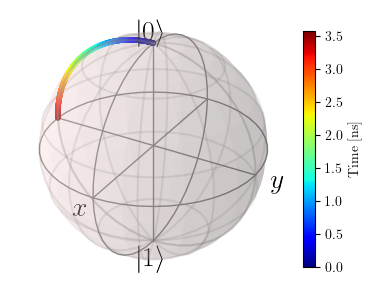

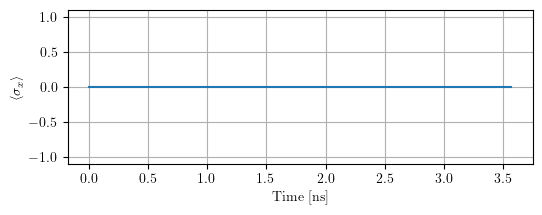

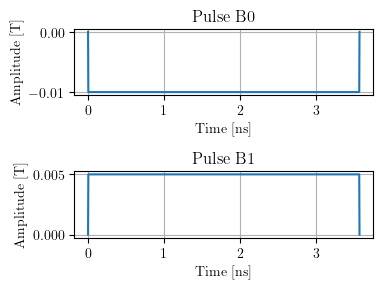

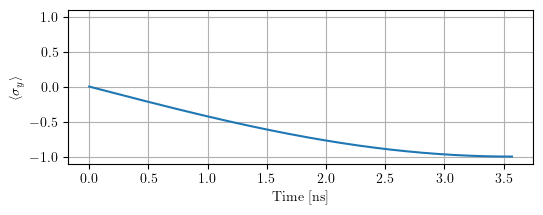

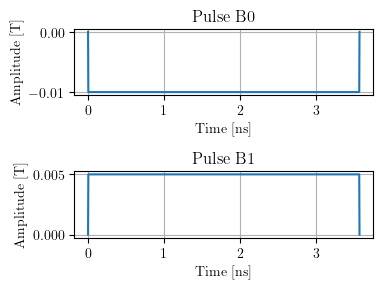

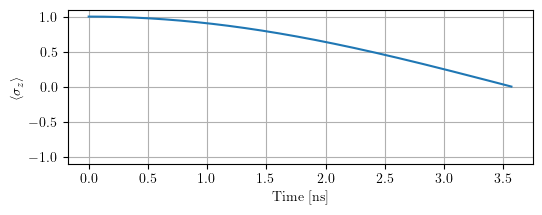

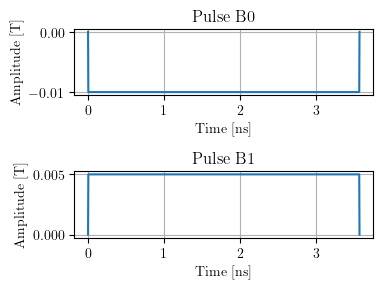

In [22]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000)
alpha = np.pi/2
out = procesor_1.Rx(alpha, ket_0, tf_expect=True)

print(out.expect[0][-1])
print(out.expect[1][-1])
print(out.expect[2][-1])

plot_expect(procesor_1, out, False, index=0)

plot_excharges(procesor_1, out, index=0, ry_tf =False, nick_name="Rx")
plot_excharges(procesor_1, out, index=1, ry_tf =False, nick_name="Rx")
plot_excharges(procesor_1, out, index=2, ry_tf =False, nick_name="Rx")

In [23]:
procesor_1.H0 + procesor_1.H1 + procesor_1.H2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.0e+00 2.2e+08]
 [2.2e+08 0.0e+00]]

#### Without noise

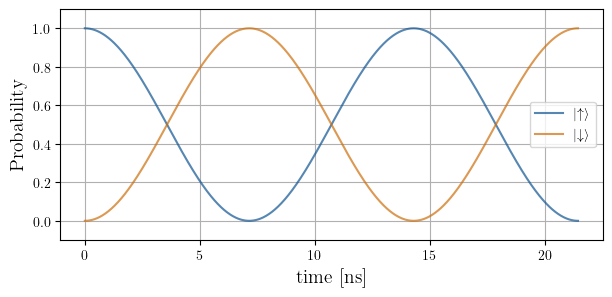

In [25]:
# Estado inicial
ket_0 = basis(2, 0)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, save_time_values=True)

# ANGULO:
alpha = 3*np.pi

out = procesor_1.Rx(alpha, ket_0, tf_expect=False)


# Measure 2:
list_overlap = [np.array([[1 ,0]]), np.array([[0 ,1]])]
t, measure = measure_quantum_states(procesor_1, list_overlap)
probability_0 = measure[0]
probability_1 = measure[1]

# plot measure:

fig, ax = plt.subplots(figsize=(7, 3))
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'uparrow') # 'uparrow'
plot_measure_continuous(ax, t, probability_1, 1, 'downarrow')
ax.set_ylabel('Probability', fontsize=14)
ax.set_xlabel('time [ns]', fontsize=14)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_Rx_in_time.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

### $R_z$

In [26]:
# Parametros para fijar frecuencia de larmor
h = 1
# factor giromagnetico:
gir = 1.760e11
# angulo deseado:
alpha = np.pi/2
# Campo homogeneo:
B0 = -10e-3
print(f"B0 = {B0} [T]")
# Para girar univamente en el eje x se necesita hacer que
# wz = wx:
ω_z = gir*B0
ω_x = 0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (alpha)/np.abs(ω_z)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = 0
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

B0 = -0.01 [T]
ω_x = 0 [rad/s]
f_x = 0.0 [hz]
tiempo = 8.924979129516458e-10 [s]
B1 = 0 [T]


In [27]:
# Simulacion sin RWA:
ket_0 = (basis(2, 0) + basis(2, 1))*(1/np.sqrt(2))

H0 = (h/2)*(ω_z)*sigmaz()
H1 = (h)*O_x*sigmax()
H = [H0,[H1, pulse_x_cos]]
args = {"t_init": 0, "t_final": delt_t, "w":ω_x}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 10000)
output_time = mesolve(H, ket_0, tlist, c_ops, e_ops, args)

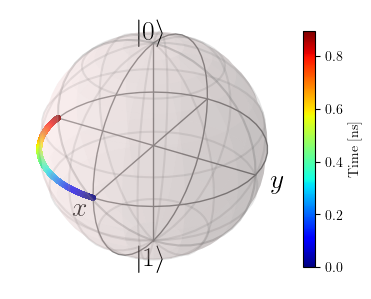

In [28]:
## create Bloch sphere instance ##
fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
b = Bloch()
b.axes = ax1
b.fig = fig
## normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(0, delt_t*1e9)
colors = cm.jet(nrm(tlist)*1e9)
## add data points from expectation values ##
b.add_points([output_time.expect[0],output_time.expect[1],output_time.expect[2]],'m')
## customize sphere properties ##
b.point_color=list(colors)
b.point_marker=['o']
b.point_size=[8]
b.view=[-9,11]
b.zlpos=[1.1,-1.2]
b.zlabel=[r"$\left| 0 \right\rangle $", r"$\left| 1 \right\rangle$"]
## plot sphere ##
## Add color bar ##
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=nrm)
sm.set_array([])  # You need to set a dummy array for the right scaling
cbar = plt.colorbar(sm, ax = ax1, orientation='vertical', shrink=0.5)
cbar.set_label('Time [ns]')
b.render()
path_to_save_img = os.path.join("results_of_test","test_2","Rz_without_RWA.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


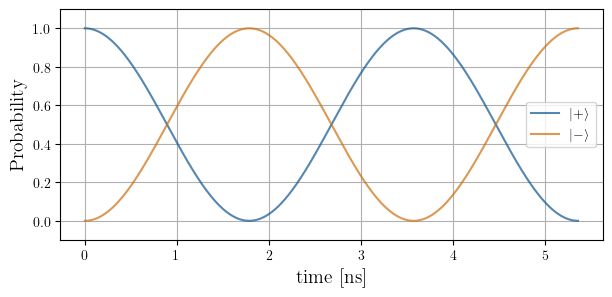

In [33]:
# Estado inicial
ket_00 = basis(2, 0)
ket_0 = (basis(2, 0) + basis(2, 1))*(1/np.sqrt(2))
ket_1 = (basis(2, 0) - basis(2, 1))*(1/np.sqrt(2))

# =================
# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, save_time_values=True)
angle = -3*np.pi
out = procesor_1.Rz(angle, ket_0, tf_expect=False)

# Measure 2:
list_overlap = [ket_0.full().T, ket_1.full().T]
t, measure = measure_quantum_states(procesor_1, list_overlap)
probability_0 = measure[0]
probability_1 = measure[1]


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous_RZ(ax, t, probability_0, 0, '+')
plot_measure_continuous_RZ(ax, t, probability_1, 1, '-')
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_Rz_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


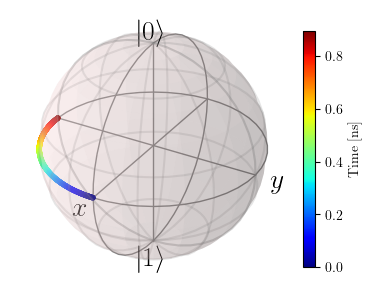

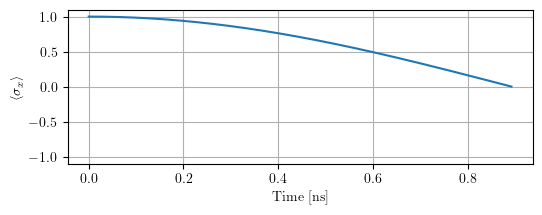

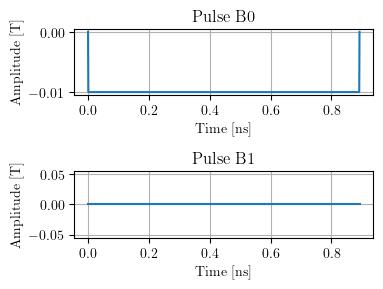

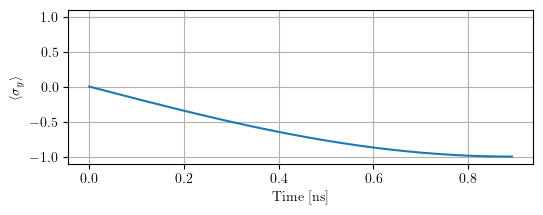

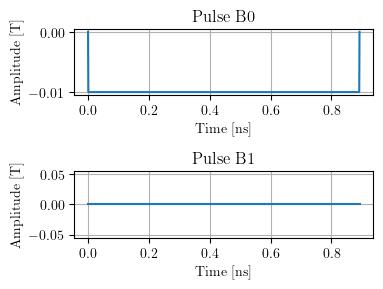

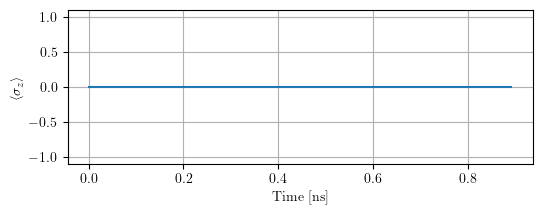

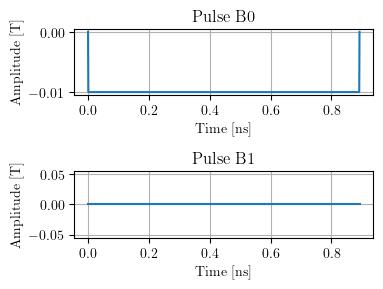

In [39]:
model = Quantum_Spin_Proces( n_points_pulse_Ri=1000)
ket_0 = (basis(2, 0) + basis(2, 1))*(1/np.sqrt(2))
angle = np.pi/2
out = model.Rz(-np.pi/2 , ket_0, tf_expect=True)


plot_expect(model, out,  ry_tf = False, index=2)

plot_excharges(model, out, index=0, ry_tf =False, nick_name="Rz")
plot_excharges(model, out, index=1, ry_tf =False, nick_name="Rz")
plot_excharges(model, out, index=2, ry_tf =False, nick_name="Rz")

In [40]:
procesor_1.H0 + procesor_1.H1 + procesor_1.H2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-8.8e+08  0.0e+00]
 [ 0.0e+00  8.8e+08]]

In [42]:
procesor_1.H0 

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-8.8e+08  0.0e+00]
 [ 0.0e+00  8.8e+08]]

In [26]:
from qutip import destroy, create

In [53]:
f = create(2)
f

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [51]:
a = destroy(2)
a

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0. 1.]
 [0. 0.]]

### $R_y$

In [43]:
def traducir_a_positivo(angulo):
    while angulo < 0:
        angulo += 2 * np.pi
    return angulo

In [44]:
# Parametros para fijar frecuencia de larmor
h = 1
# factor giromagnetico:
gir = 1.760e11
# Campo homogeneo:
B0 = -10e-3
print(f"B0 = {B0} [T]")

# ket inicial
ket_0 = basis(2, 0)

# RZ (-pi/2)
# ==================================
# angulo deseado:
alpha = np.pi/2
alpha  = traducir_a_positivo(alpha)
# frecuencias:
ω_z = gir*B0
ω_x = 0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (alpha)/np.abs(ω_z)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = 0
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

# Solver
H0 = (h/2)*(ω_z-ω_x)*sigmaz()
H1 = (h/2)*O_x*sigmax()
H = [H0,[H1, pulse_x]]
args = {"t_init": 0, "t_final": delt_t}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)

output_rwa_1_exp = mesolve(H, ket_0, tlist, c_ops, e_ops, args)
output_rwa_1_states = mesolve(H, ket_0, tlist, c_ops, [], args)
end_state_1 = output_rwa_1_states.states[-1]


# Rx (theta)
# ==================================
# angulo deseado:
alpha = -np.pi/4
# Para girar univamente en el eje x se necesita hacer que
# wz = wx:
ω_z = gir*B0
ω_x = gir*B0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (np.abs(alpha)*4)/np.abs(ω_x)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = (alpha*2)/(gir*delt_t)
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

# Solver
H0 = (h/2)*(ω_z)*sigmaz()
H1 = (h)*O_x*sigmax()
H = [H0,[H1, pulse_x_cos]]
args = {"t_init": 0, "t_final": delt_t, "w":ω_x}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)
tlist_c = tlist.copy()
output_rwa_2_exp = mesolve(H, end_state_1, tlist, c_ops, e_ops, args)
output_rwa_2_states = mesolve(H, end_state_1, tlist, c_ops, [], args)
end_state_2 = output_rwa_2_states.states[-1]

# RZ (-pi/2)
# ==================================
# angulo deseado:
alpha = -np.pi/2
alpha  = traducir_a_positivo(alpha)
# frecuencias:
ω_z = gir*B0
ω_x = 0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (alpha)/np.abs(ω_z)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = 0
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

# Solver
H0 = (h/2)*(ω_z-ω_x)*sigmaz()
H1 = (h/2)*O_x*sigmax()
H = [H0,[H1, pulse_x]]
args = {"t_init": 0, "t_final": delt_t}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)
output_rwa_3_exp = mesolve(H, end_state_2, tlist, c_ops, e_ops, args)
output_rwa_3_states = mesolve(H, end_state_2, tlist, c_ops, [], args)
end_state_3 = output_rwa_3_states.states[-1]

B0 = -0.01 [T]
ω_x = 0 [rad/s]
f_x = 0.0 [hz]
tiempo = 8.924979129516458e-10 [s]
B1 = 0 [T]
ω_x = -1760000000.0 [rad/s]
f_x = -280112699.8417358 [hz]
tiempo = 1.7849958259032916e-09 [s]
B1 = -0.005 [T]
ω_x = 0 [rad/s]
f_x = 0.0 [hz]
tiempo = 2.6774937388549373e-09 [s]
B1 = 0 [T]


In [45]:
# Parametros para fijar frecuencia de larmor
h = 1
# factor giromagnetico:
gir = 1.760e11
# Campo homogeneo:
B0 = -10e-3
print(f"B0 = {B0} [T]")

# ket inicial
ket_0 = basis(2, 0)

# Rx (pi/2)
# ==================================
# angulo deseado:
alpha = np.pi/2
# Para girar univamente en el eje x se necesita hacer que
# wz = wx:
ω_z = gir*B0
ω_x = gir*B0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (np.abs(alpha)*4)/np.abs(ω_x)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = (alpha*2)/(gir*delt_t)
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

# Solver
H0 = (h/2)*(ω_z)*sigmaz()
H1 = (h)*O_x*sigmax()
H = [H0,[H1, pulse_x_cos]]
args = {"t_init": 0, "t_final": delt_t, "w":ω_x}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)
tlist_c = tlist.copy()
output_rwa_1_exp = mesolve(H, ket_0, tlist, c_ops, e_ops, args)
output_rwa_1_states = mesolve(H, ket_0, tlist, c_ops, [], args)
end_state_1 = output_rwa_1_states.states[-1]



# RZ (tehta)
# ==================================
# angulo deseado:
alpha = 1.6*np.pi/2
alpha  = traducir_a_positivo(alpha)
# frecuencias:
ω_z = gir*B0
ω_x = 0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (alpha)/np.abs(ω_z)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = 0
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

# Solver
H0 = (h/2)*(ω_z-ω_x)*sigmaz()
H1 = (h/2)*O_x*sigmax()
H = [H0,[H1, pulse_x]]
args = {"t_init": 0, "t_final": delt_t}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)
output_rwa_2_exp = mesolve(H, end_state_1, tlist, c_ops, e_ops, args)
output_rwa_2_states = mesolve(H, end_state_1, tlist, c_ops, [], args)
end_state_2 = output_rwa_2_states.states[-1]




# Rx (theta)
# ==================================
# angulo deseado:
alpha = -np.pi/2
# Para girar univamente en el eje x se necesita hacer que
# wz = wx:
ω_z = gir*B0
ω_x = gir*B0
print(f"ω_x = {ω_x} [rad/s]")
print(f"f_x = {ω_x/(2*np.pi)} [hz]")
# Delta de tiempo para que se mueva el espin a un ciclo:
delt_t = (np.abs(alpha)*4)/np.abs(ω_x)
print(f"tiempo = {delt_t} [s]")
# Calculo de B1:
B1 = (alpha*2)/(gir*delt_t)
print(f"B1 = {B1} [T]")
# Omega x:
O_x = gir*(B1/2)

# Solver
H0 = (h/2)*(ω_z)*sigmaz()
H1 = (h)*O_x*sigmax()
H = [H0,[H1, pulse_x_cos]]
args = {"t_init": 0, "t_final": delt_t, "w":ω_x}
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
tlist  = np.linspace(0, delt_t, 1000)
tlist_c = tlist.copy()
output_rwa_3_exp = mesolve(H, end_state_2, tlist, c_ops, e_ops, args)
output_rwa_3_states = mesolve(H, end_state_2, tlist, c_ops, [], args)
end_state_3 = output_rwa_3_states.states[-1]

B0 = -0.01 [T]
ω_x = -1760000000.0 [rad/s]
f_x = -280112699.8417358 [hz]
tiempo = 3.5699916518065832e-09 [s]
B1 = 0.005 [T]
ω_x = 0 [rad/s]
f_x = 0.0 [hz]
tiempo = 1.4279966607226333e-09 [s]
B1 = 0 [T]
ω_x = -1760000000.0 [rad/s]
f_x = -280112699.8417358 [hz]
tiempo = 3.5699916518065832e-09 [s]
B1 = -0.005 [T]


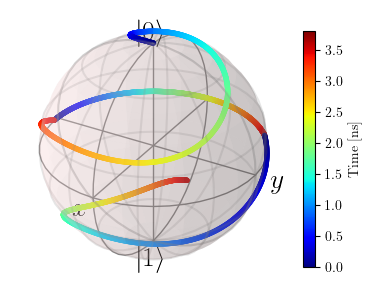

In [46]:
import matplotlib as mpl
from matplotlib import cm
## create Bloch sphere instance ##
fig = plt.figure(constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
b=Bloch()
b.axes = ax1
b.fig = fig
## normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(0,3.8e-09*1e9)
colors = cm.jet(nrm(tlist_c*1e9))
## add data points from expectation values ##
b.add_points([output_rwa_1_exp.expect[0],output_rwa_1_exp.expect[1],output_rwa_1_exp.expect[2]],'m')
b.add_points([output_rwa_2_exp.expect[0],output_rwa_2_exp.expect[1],output_rwa_2_exp.expect[2]],'m')
b.add_points([output_rwa_3_exp.expect[0],output_rwa_3_exp.expect[1],output_rwa_3_exp.expect[2]],'m')
## customize sphere properties ##
b.point_color=list(colors)
b.point_marker=['o']
b.point_size=[8]
b.view=[-9,11]
b.zlpos=[1.1,-1.2]
b.zlabel=[r"$\left| 0 \right\rangle $", r"$\left| 1 \right\rangle$"]
sm = plt.cm.ScalarMappable(cmap=cm.jet, norm=nrm)
sm.set_array([])  # You need to set a dummy array for the right scaling
cbar = plt.colorbar(sm, ax = ax1, orientation='vertical', shrink=0.5)
cbar.set_label('Time [ns]')
b.render()
path_to_save_img = os.path.join("results_of_test","test_2","Ry_without_RWA.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


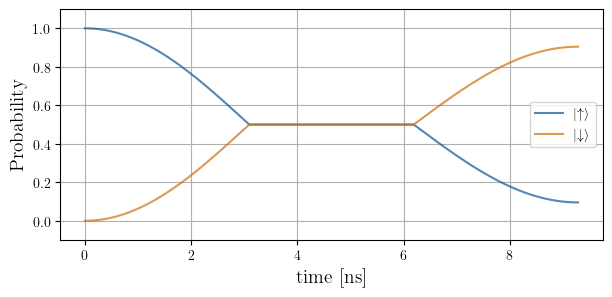

In [35]:
# Estado inicial
ket_0 = basis(2, 0)

# =================
# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000,  save_time_values = True)
angle = 1.6*np.pi/2
out = procesor_1.Ry(angle, ket_0, tf_expect=False)

# Measure:
list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t, measure = measure_quantum_states(procesor_1, list_states_overlap)
probability_0 = measure[0]
probability_1 = measure[1]

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, t, probability_0, 0, 'uparrow')
plot_measure_continuous(ax, t, probability_1, 1,  'downarrow')
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_Ry_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


#### Bloch sphere visualization

In [10]:
model = Quantum_Spin_Proces( n_points_pulse_Ri=1000, save_pulses=True)
ket_0 = basis(2, 0)
angle = 1.6*np.pi/2
out = model.Ry(angle , ket_0, tf_expect=False)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [11]:
model.pulse_type

defaultdict(list,
            {0: [{'Type_pulse': 'Unitary',
               'B0': -0.01,
               'B1': 0.005,
               'Delt_t': 3.5699916518065832e-09,
               'Q_bits_target': 0,
               't_i': 0,
               't_f': 3.5699916518065832e-09,
               'Noise': ''},
              {'Type_pulse': 'Unitary',
               'B0': -0.01,
               'B1': 0,
               'Delt_t': 2.14199499108395e-09,
               'Q_bits_target': 0,
               't_i': 3.5699916518065832e-09,
               't_f': 5.711986642890533e-09,
               'Noise': ''},
              {'Type_pulse': 'Unitary',
               'B0': -0.01,
               'B1': -0.005,
               'Delt_t': 3.5699916518065832e-09,
               'Q_bits_target': 0,
               't_i': 5.711986642890533e-09,
               't_f': 9.281978294697117e-09,
               'Noise': ''}]})

In [4]:
model.B1

-0.005

In [18]:
def plot_pulses_v2(self, verbose = 1, key_show = 'all', entangl = False, plot_old_version = False):
  # Tomar todos los pulsos:
  resultado = self.pulse_type
  # Definir el tiempo global de simulacion:
  glob_time = self.global_time
  # Por cada pulso...
  for key in resultado:
    # Identificar su tipo:
    list_pulses = resultado[key]
    # Caso pulso unitario:
    if list_pulses[0]['Type_pulse'] == 'Unitary':
      global_time_sim = np.linspace(0, glob_time , 1000) # Tiempo total de simulacion
      B1_pulses = np.zeros(len(global_time_sim )) # vect. para guardar pulso Bx
      B0_pulses = np.zeros(len(global_time_sim )) # vect. para guardar pulso B0
      for dict_pulse in list_pulses:
        # B0 results
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        B0_i = dict_pulse['B0'] * pulse_z(
                                  global_time_sim,
                                  args2)
        # Se guarda reiterativamente los pulsos cuadrados:
        B0_pulses += np.array(B0_i)
        # B1 results
        # Correccion desviacion estandar:
        if self.tf_noise == True:
          if dict_pulse['B1'] != 0:
            dv = self.noise_std/abs(dict_pulse['B1'])
          else:
            dv = 0
        else:
          dv = 0
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f'], "std_noise": dv }
        B1_i = dict_pulse['B1'] * pulse_x_with_noise(
                                  global_time_sim,
                                  args2)
        # Se guarda reiterativamente los pulsos cuadrados:
        B1_pulses += np.array(B1_i)
      # Plot
      # =================================================================
      # Extrar informacion de las I virtuales:
      B0_pulses_blue, B0_pulses_red = make_total_pulse(np.abs(B0_pulses))
      # poner inicio en 0
      B0_pulses_blue[0] = 0
      B0_pulses_blue[-1] = 0
      B0_pulses_red[0] = 0
      B0_pulses_red[-1] = 0 
      # Graficar los valores reales mayores que cero en azul
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim* 1e9, np.abs(B0_pulses),linewidth=0.5, color='darkblue') # BORRAR
      plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')
      plt.plot(global_time_sim* 1e9, B0_pulses_red, 'r-', label=r'Virtual $I$ gate')
      plt.title("Pulse sequence for B0")
      plt.xlabel("time [ns]")
      plt.ylabel("B0 [T]")
      plt.grid()
      if self.N_qubits > 1:
        plt.legend()
      plt.rcParams['text.usetex'] = True
      plt.rcParams['font.family'] = 'Times New Roman'
      path_to_save_img = os.path.join("results_of_test","test_2",f"B0_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
      plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
      plt.show()

      # Grafica para B1:
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim* 1e9, B1_pulses,linewidth=1.7, color='darkblue')
      plt.title("Pulse sequence for B1")
      plt.xlabel("time [ns]")
      plt.ylabel("B1 [T]")
      plt.grid()
      plt.rcParams['text.usetex'] = True
      plt.rcParams['font.family'] = 'Times New Roman'
      path_to_save_img = os.path.join("results_of_test","test_2", f"B1_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
      plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
      plt.show()
      
      if plot_old_version == True:
        # ===========================
        plt.figure(figsize=(4, 3))
        plt.subplot(2, 1, 1)  # 2 filas, 1 columna, segundo subplot
        plt.plot(global_time_sim* 1e9, B0_pulses)
        plt.title('Pulse B0')
        plt.xlabel('Time [ns]')
        plt.ylabel('Amplitude [T]')
        plt.grid(True)
        # Subplot para el pulso
        plt.subplot(2, 1, 2)  # 2 filas, 1 columna, segundo subplot
        plt.plot(global_time_sim* 1e9, B1_pulses)
        plt.title('Pulse B1')
        plt.xlabel('Time [ns]')
        plt.ylabel('Amplitude [T]')
        plt.grid(True)
        
        plt.tight_layout()
        path_to_save_img = os.path.join("results_of_test","test_2", f"B1_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
        plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
        plt.show()
      

    elif list_pulses[0]['Type_pulse'] == "Two_Qubits":
      # Tiempo global de simulación:
      global_time_sim = np.linspace(0, glob_time, 100000)
      # vector para definir el pulso, inicializandolo en 0:
      J_pulses = np.zeros(len(global_time_sim ))
      # def figura:
      fig, ax = plt.subplots(figsize=(8,3))
      # por cada pulso...
      for th, dict_pulse in enumerate(list_pulses):
        t_i = dict_pulse['t_i'] # t inicial
        t_f = dict_pulse['t_f'] # tiempo final
        J = dict_pulse['J'] # amplitud de J
        duration = t_f - t_i # duracion pulso
        Swap_time = np.pi/(J) # tiempo esperado para SWAP
        sqrt_Swap_time = np.pi/(2*J) # tiempo esperado para sqrt SWAP
        # identificar tipo de pulso
        label = "SWAP" if abs(duration - Swap_time) < 1e-13 else r"$\sqrt{SWAP}$" if abs(duration - sqrt_Swap_time) < 1e-13 else "Unknown"
        #print(f"Duracion real = {duration}, swap = {Swap_time}, sqrt swap = {sqrt_Swap_time}, label = {label}")
        args2 = {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        J_i = dict_pulse['J'] * pulse_x(
                                  global_time_sim,
                                  args2)
        # Actualizar pulsos de forma reiterativa:
        J_pulses += np.array(J_i)
        
        # Añadir el texto sobre el pulso
        t_center = (t_f + t_i) / 2 # Definir centro
        # Posicion en y del texto:
        if label == "SWAP":
          y_text = dict_pulse['J']*1.05
        else:
          y_text = dict_pulse['J']*1.05
        # add text:
        ax.text((t_center*1e9)*np.random.uniform(0.99, 1.00), y_text*1e-12,
                label, horizontalalignment='center',
                verticalalignment='bottom', rotation=90, fontsize=5)
      # Plot
      # ==================================================================
      ax.plot(global_time_sim*1e9, J_pulses*1e-12, linewidth=1.7, color='darkblue')
      ax.set_xlabel("time [ns]")
      ax.set_ylabel("J [meV]")
      ax.set_ylim([0, (np.max(J_pulses)*1e-12)*1.30])
      plt.rcParams['text.usetex'] = True
      plt.rcParams['font.family'] = 'Times New Roman'
      plt.grid()
      path_to_save_img = os.path.join("results_of_test","test_2", f"J_PSeq_{self.N_qubits}_entgl_{entangl}_q_obj_{key}.pdf")
      plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
      plt.show()

In [19]:
def make_total_pulse(B0_pulses):
  # Convertir el array a tipo float para poder asignar NaN
  B0_pulses = B0_pulses.astype(float)

  # Crear un vector complementario donde los ceros se reemplazan por unos
  B0_complement = np.where(B0_pulses == 0, np.max(B0_pulses), B0_pulses)

  # Crear una máscara para los valores que son cero en el vector original
  mask = B0_pulses == 0

  # Crear una copia del vector original para graficar los valores reales mayores que cero
  B0_pulses_real = np.copy(B0_pulses)
  B0_pulses_real[mask] = np.nan  # Reemplazar los ceros con NaN para no plotearlos

  # Crear una copia del vector complementario para graficar los valores complementados
  B0_pulses_complement = np.copy(B0_complement)
  B0_pulses_complement[~mask] = np.nan  # Reemplazar los valores no complementados con NaN
  
  return B0_complement, B0_pulses_complement

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1675831050.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(global_time_sim* 1e9,B0_pulses_blue, 'b-', label=r'Real $B_0$',color='darkblue')


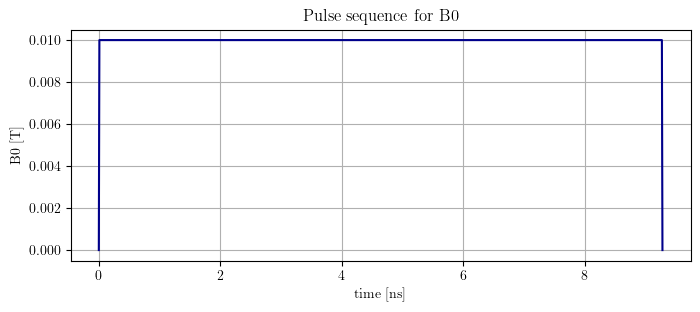

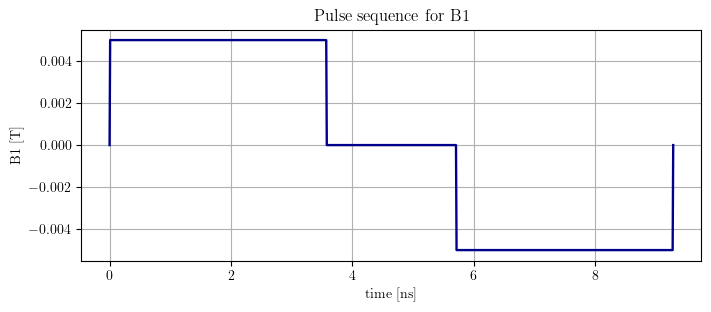

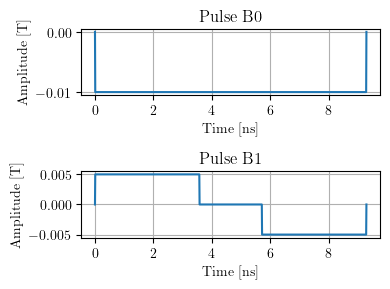

In [20]:
plot_pulses_v2(model, plot_old_version = True)

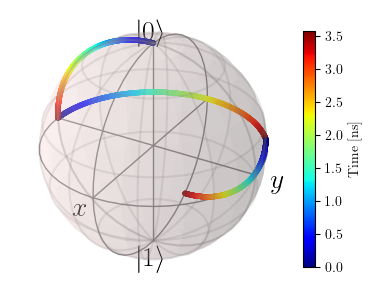

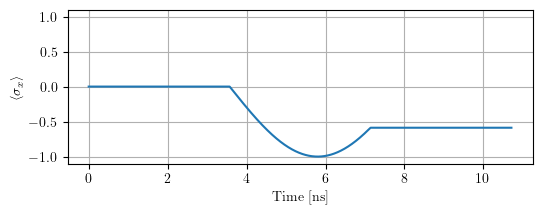

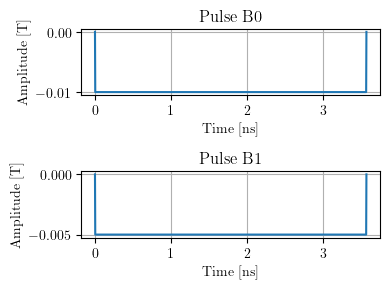

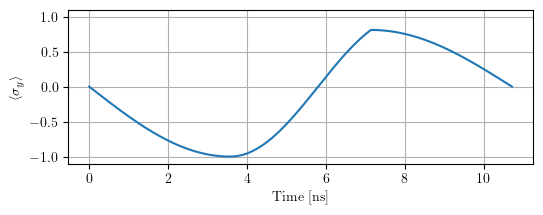

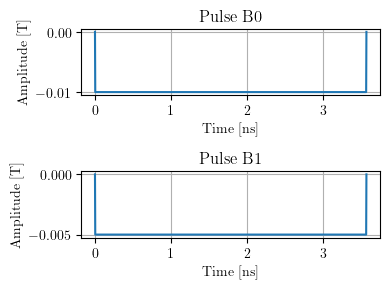

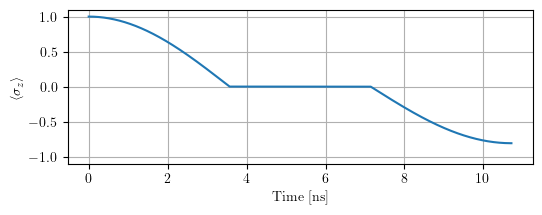

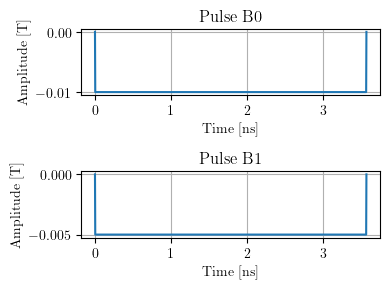

In [22]:

model = Quantum_Spin_Proces( n_points_pulse_Ri=1000, save_pulses=True)
ket_0 = basis(2, 0)
angle = -1.6*np.pi/2
out = model.Ry(angle , ket_0, tf_expect=True)


plot_expect(model, out,  True, index=1)

plot_excharges(model, out, index=0, ry_tf =True, nick_name="Ry")
plot_excharges(model, out, index=1, ry_tf =True, nick_name="Ry")
plot_excharges(model, out, index=2, ry_tf =True, nick_name="Ry")

### $L(i)$


#### Fit base line { $\omega^{*}$, $\theta^{*}$ }

In [36]:
N_layeres = 2
n_classes = 3
n_features = 2


X, y =  make_IRIS_v2(n_features, n_classes)


model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                   epochs = 1, n_clases = n_classes, n_qubits = 1,
                   features = n_features, alpha_noise = 0.0, save_process=False,
                   num_layers = N_layeres)

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

Epoch: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


#### Spin processor

In [37]:
# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000, n_points_pulse_Ri_spl=1000, N_qubits = 1,
                                    tf_noise = False, noise_std = 0.019,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c, save_time_values=True)
state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)


list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
t, probability_0, probability_1 = measure_compuse_states(dru_circuit, list_states_overlap)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [59]:
t[0], t[-1]

(0.0, 2.2420418818460292e-08)

In [60]:
t[0]*1e9, t[-1]*1e9

(0.0, 22.42041881846029)

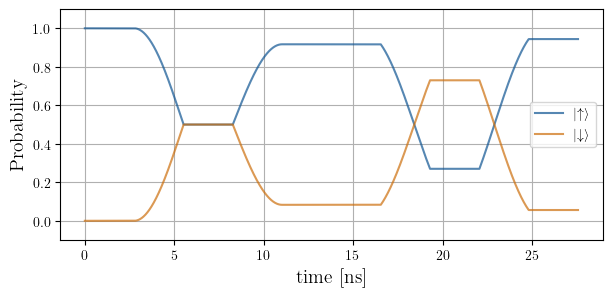

In [39]:
# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plot_measure_continuous(ax, t, probability_0, 0, 'uparrow')
plot_measure_continuous(ax, t, probability_1, 1, 'downarrow')

ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_L_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

## 1 Qubit - frecuencia

### $L(i)$

Si se quitar el parametro de f_range (f_range = 0) el valor al cual se coloca w_x = 1760000000 Hz

In [33]:
f_range = np.linspace( -1760000000*0.7, 1760000000*0.7, 100)
ket_0 = basis(2, 0)
S = []

list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]
Tau = 5.5740340901988396*1e-8
t_ends = []
for fi in f_range:
    procesor_1 = CompositeGateProcessor(n_points_pulse_Ri = 100, f_rage = fi, ket_dru_0=ket_0, save_time_values=True)
    state_dru = procesor_1.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)
    t, probability_0, probability_1 = measure_compuse_states(procesor_1, list_states_overlap)
    #print(t[0], t[-1], len(probability_0))
    t_ends.append(t[-1])
    
for i, fi in enumerate(f_range):
    free_time = (Tau - t_ends[i])/10 # se divide porque son 10 R_i que se aplican.
    procesor_1 = CompositeGateProcessor(n_points_pulse_Ri = 100, f_rage = fi, ket_dru_0=ket_0, save_time_values=True, free_time=free_time)
    state_dru = procesor_1.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)
    t, probability_0, probability_1 = measure_compuse_states(procesor_1, list_states_overlap)
    #print(t[0], t[-1], len(probability_0))
    S.append(probability_1)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


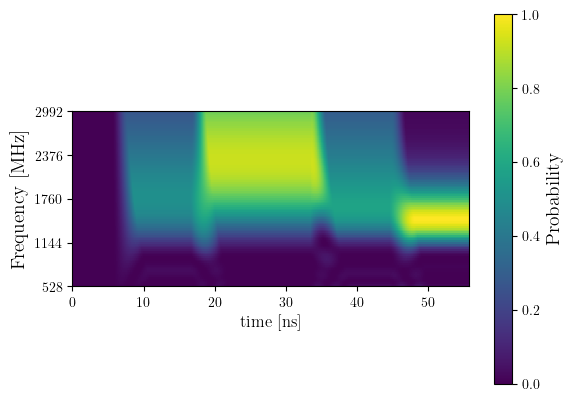

In [34]:
# Crear la figura y el eje para la imagen
fig, ax = plt.subplots()
f_range = np.linspace( -1760000000*0.7, 1760000000*0.7, 100)
datos_np = np.array(S)
# Mostrar la imagen con intensidades normalizadas
imagen = ax.imshow(datos_np, cmap='viridis', interpolation='nearest',
                   extent=[t[0]*1e9, t[-1]*1e9, f_range[0]/1e8, f_range[-1]/1e8]
)
# Agregar barra de colores
colorbar = fig.colorbar(imagen)
# Agregar etiquetas de los ejes
offset = 1760000000

# Agregar ejes
ax.set_xlabel(r'time [ns]', fontsize=12)
ax.set_ylabel(r'Frequency [MHz]', fontsize=14)
imagen.set_clim(0, 1)
colorbar.set_label('Probability', fontsize=14)

# Calcular las posiciones de los ticks en el eje y
yticks = np.linspace(f_range[0] / 1e8, f_range[-1] / 1e8, num=5)  # Ajusta el número de ticks según sea necesario
ytick_labels = (yticks * 1e8 + offset) / 1e6  # Sumar el offset y convertir a MHz

# Establecer los nuevos ticks y etiquetas en el eje y
ax.set_yticks(yticks)
ax.set_yticklabels([f'{label:.0f}' for label in ytick_labels])
path_to_save_img = os.path.join("results_of_test","test_2","frecuency_L.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

### $R_x$

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


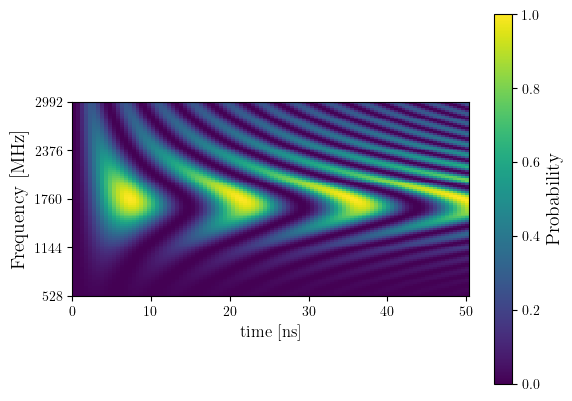

In [32]:
f_range = np.linspace( -1760000000*0.7, 1760000000*0.7, 100)
ket_0 = basis(2, 1)
S = []
alpha = 8*np.pi
list_states_overlap = [np.array([[1, 0]]), np.array([[0, 1]])]

tau = 50.39955476301776*1e-9

for fi in f_range:
    procesor_1 = CompositeGateProcessor(n_points_pulse_Ri = 100, f_rage = fi,  save_time_values=True, nf = 4)
    
    # calculo:
    angle = (tau/4)*(procesor_1.gir * procesor_1.B0 + fi)
    
    state_dru = procesor_1.Rx(angle, ket_0)
    t,probability_0, probability_1 = measure_compuse_states(procesor_1, list_states_overlap)
    #print(t[0]*1e9, t[-1]*1e9, len(probability_0))
    S.append(probability_0)

# Crear la figura y el eje para la imagen
fig, ax = plt.subplots()
datos_np = np.array(S)
# Mostrar la imagen con intensidades normalizadas
imagen = ax.imshow(datos_np, cmap='viridis', interpolation='nearest',
                    extent=[t[0]*1e9, t[-1]*1e9, f_range[0]/1e8, f_range[-1]/1e8])
# Agregar barra de colores
colorbar = fig.colorbar(imagen)


# Agregar ejes
ax.set_xlabel(r'time [ns]', fontsize=12)
ax.set_ylabel(r'Frequency [MHz]', fontsize=14)
imagen.set_clim(0, 1)
colorbar.set_label('Probability', fontsize=14)

# Calcular las posiciones de los ticks en el eje y
yticks = np.linspace(f_range[0] / 1e8, f_range[-1] / 1e8, num=5)  # Ajusta el número de ticks según sea necesario
ytick_labels = (yticks * 1e8 + offset) / 1e6  # Sumar el offset y convertir a MHz

# Establecer los nuevos ticks y etiquetas en el eje y
ax.set_yticks(yticks)
ax.set_yticklabels([f'{label:.0f}' for label in ytick_labels])
path_to_save_img = os.path.join("results_of_test","test_2","frecuency_Rx.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


## 2 Qubits - tiempo

#### SWAP

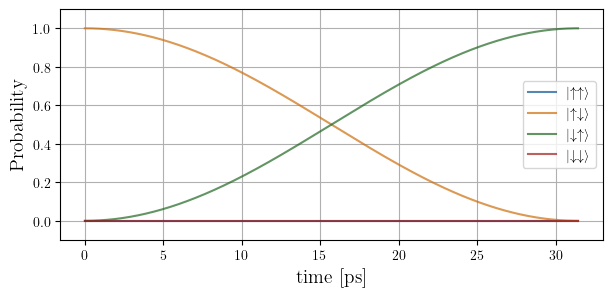

In [24]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 0),basis(2, 1))


# Def procesador
T2c = 22e-4
T2start = 1042e-4
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2, n_points_pulse_2Qbits=1000, n_points_pulse_Ri_spl=1000,
                                J = 0.1e12, tf_noise = False,
                                noise_std = 0.0000019,
                                tf_quantum_noise = False,
                                T1= T1c, T2 = T2c,  save_time_values=True)
angle = 5*np.pi
out = procesor_1.SWAP(ket_0, [], tf_expectt=False)



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                        np.array([[0, 0, 0, 1]])]

time, m = measure_quantum_states(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, time * 1000, m[0], 0, [r"\uparrow", r"\uparrow"])
plot_measure_continuous(ax, time* 1000, m[1], 1, [r"\uparrow", r"\downarrow"])
plot_measure_continuous(ax, time* 1000, m[2], 2, [r"\downarrow", r"\uparrow"])
plot_measure_continuous(ax, time* 1000, m[3], 3, [r"\downarrow", r"\downarrow"])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ps]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_SWAP_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()


#### $\sqrt{SWAP}$

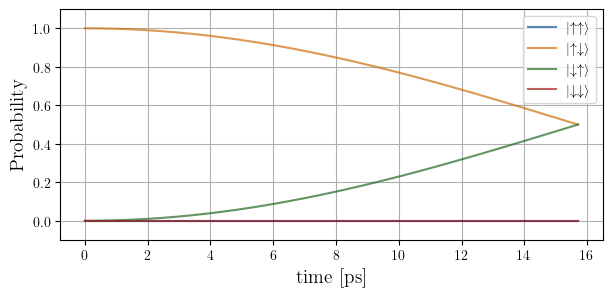

In [25]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 0),basis(2, 1))


# Def procesador
T2c = 22e-4
T2start = 1042e-4
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,n_points_pulse_2Qbits=1000,
                                 tf_noise = False,
                                noise_std = 0.0000019,
                                tf_quantum_noise = False,
                                T1= T1c, T2 = T2c, save_time_values=True)

out = procesor_1.sqrt_SWAP(ket_0, [], tf_expectt=False)



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                        np.array([[0, 0, 0, 1]])]

time, m = measure_quantum_states(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, time* 1000, m[0], 0, [r"\uparrow", r"\uparrow"])
plot_measure_continuous(ax, time* 1000, m[1], 1, [r"\uparrow", r"\downarrow"])
plot_measure_continuous(ax, time* 1000, m[2], 2, [r"\downarrow", r"\uparrow"])
plot_measure_continuous(ax, time* 1000, m[3], 3, [r"\downarrow", r"\downarrow"])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ps]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_sqrt_SWAP_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

#### CZ

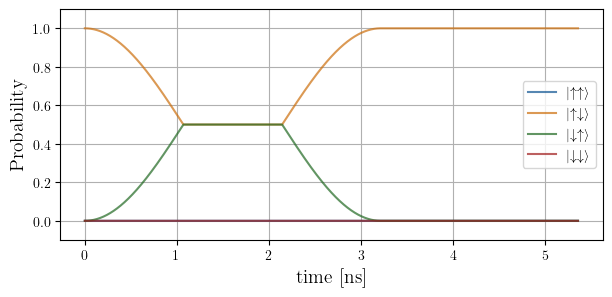

In [35]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 0),basis(2, 1))


# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,
                                  J = 1e12, tf_noise = False, noise_std = 0.019,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c, save_time_values=True, n_points_pulse_2Qbits=1000)

out = procesor_1.CZ(ket_0, [], tf_expectt=False)



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                        np.array([[0, 0, 0, 1]])]

time, m = measure_quantum_states(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, time, m[0], 0, [r"\uparrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[1], 1, [r"\uparrow", r"\downarrow"])
plot_measure_continuous(ax, time, m[2], 2, [r"\downarrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[3], 3, [r"\downarrow", r"\downarrow"])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_sqrt_CZ_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

#### CNOT

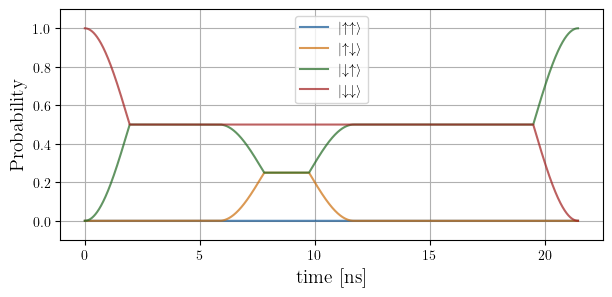

In [40]:
# Estado inicial
from qutip import tensor
ket_0 = tensor(basis(2, 1),basis(2, 1))

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2, save_time_values=True, n_points_pulse_2Qbits=1000)
out = procesor_1.CNOT(ket_0, [], tf_expectt=False, q_obj = [0,1])



list_states_overlap = [np.array([[1, 0, 0, 0]]),
                       np.array([[0, 1, 0, 0]]),
                       np.array([[0, 0, 1, 0]]),
                        np.array([[0, 0, 0, 1]])]
time, m = measure_quantum_states(procesor_1, list_states_overlap)


# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
plot_measure_continuous(ax, time, m[0], 0, [r"\uparrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[1], 1, [r"\uparrow", r"\downarrow"])
plot_measure_continuous(ax, time, m[2], 2, [r"\downarrow", r"\uparrow"])
plot_measure_continuous(ax, time, m[3], 3, [r"\downarrow", r"\downarrow"])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_CNOT_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

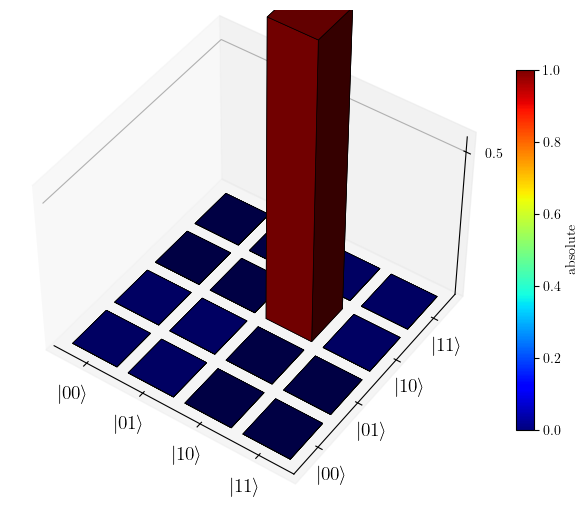

In [10]:
from qutip import matrix_histogram
latex_strings = [
    r"$|00\rangle$",
    r"$|01\rangle$",
    r"$|10\rangle$",
    r"$|11\rangle$"
]
fig, ax = matrix_histogram(out * out.dag(), latex_strings, latex_strings,
                           limits = [0.,0.55], color_limits = [0.,1], color_style="abs")
ax.view_init(azim=-55, elev=45)
path_to_save_img = os.path.join("results_of_test","test_2","tomography_CNOT.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

#### Bell states

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


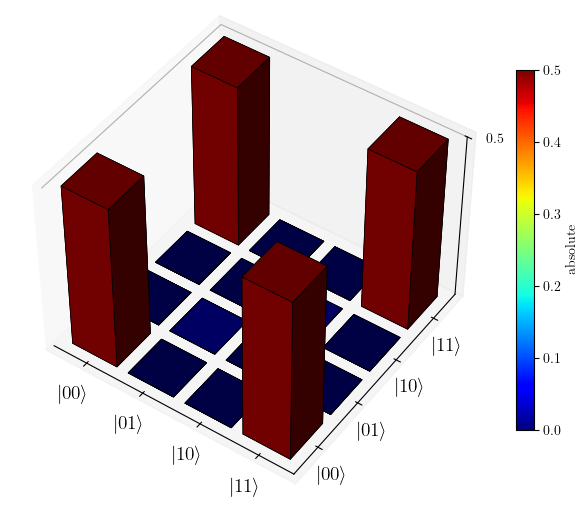

In [47]:
from qutip import tensor, basis
from qutip import matrix_histogram

ket_0 = tensor(basis(2, 0),basis(2, 0))

latex_strings = [
    r"$|00\rangle$",
    r"$|01\rangle$",
    r"$|10\rangle$",
    r"$|11\rangle$"
]

# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,
                                   tf_noise = False, noise_std = 0.0059,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c)

out = procesor_1.H(ket_0, q_obj=0).states[-1]
out = procesor_1.CNOT(out, [], tf_expectt=False)

fig, ax = matrix_histogram(out * out.dag(), latex_strings, latex_strings,
                           limits = [0.,0.50], color_limits = [0.,0.5], color_style="abs")
ax.view_init(azim=-55, elev=45)
path_to_save_img = os.path.join("results_of_test","test_2","tomography_bell_1.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


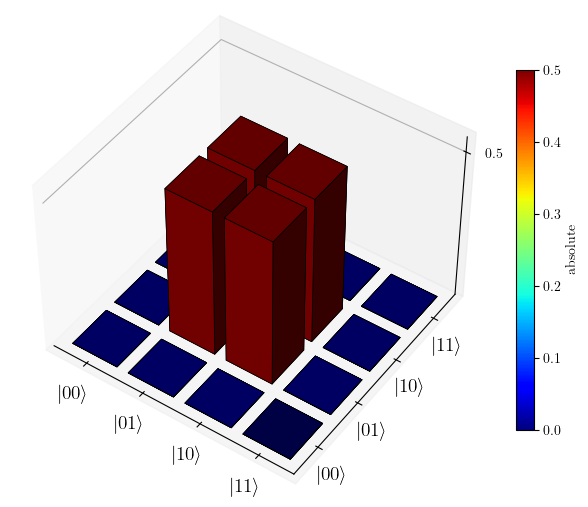

In [12]:
from qutip import tensor, basis
from qutip import matrix_histogram

ket_0 = tensor(basis(2, 0),basis(2, 1))

# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2, n_points_pulse_2Qbits=1000,
                                  J = 1e12, tf_noise = False, noise_std = 0.059,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c)

out = procesor_1.H(ket_0, q_obj=0).states[-1]
out = procesor_1.CNOT(out, [], tf_expectt=False)

fig, ax = matrix_histogram(out * out.dag(), latex_strings, latex_strings,
                           limits = [0.,0.55], color_limits = [0.,0.5], color_style="abs")
ax.view_init(azim=-55, elev=45)
path_to_save_img = os.path.join("results_of_test","test_2","tomography_bell_2.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


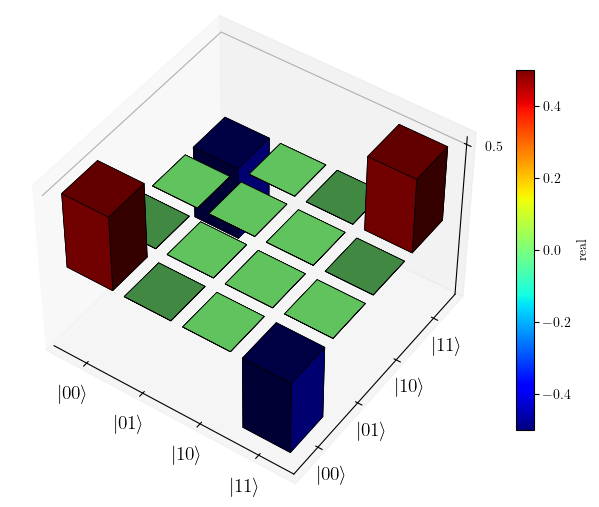

In [13]:
from qutip import tensor, basis
from qutip import matrix_histogram

ket_0 = tensor(basis(2, 1),basis(2, 0))

# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2, 
                                  J = 1e12, tf_noise = False, noise_std = 0.059,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c)

out = procesor_1.H(ket_0, q_obj=0).states[-1]
out = procesor_1.CNOT(out, [], tf_expectt=False)

fig, ax = matrix_histogram(out * out.dag(), latex_strings, latex_strings,
                           limits = [-0.55,0.55], color_limits = [-0.5,0.5], color_style="real")
ax.view_init(azim=-55, elev=45)
path_to_save_img = os.path.join("results_of_test","test_2","tomography_bell_3.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


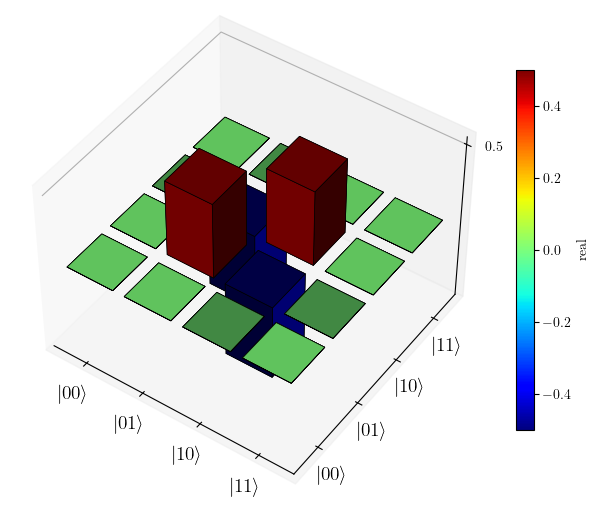

In [14]:
from qutip import tensor, basis
from qutip import matrix_histogram

ket_0 = tensor(basis(2, 1),basis(2, 1))

# Def procesador
T2c = 22e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)

# Def procesador
procesor_1 = Quantum_Spin_Proces(n_points_pulse_Ri = 1000, N_qubits=2,
                                  J = 1e12, tf_noise = False, noise_std = 0.059,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c)

out = procesor_1.H(ket_0, q_obj=0).states[-1]
out = procesor_1.CNOT(out, [], tf_expectt=False)

fig, ax = matrix_histogram(out * out.dag(), latex_strings, latex_strings,
                           limits = [-0.55,0.55], color_limits = [-0.5,0.5], color_style="real")
ax.view_init(azim=-55, elev=45)
path_to_save_img = os.path.join("results_of_test","test_2","tomography_bell_4.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()

## 4 Qubits - tiempo

In [15]:
def measure_compuse_states_2q(procesor, list_states_overlap):

    n_states_time = len(procesor.states_in_time)
    Measure_i = [[] for _ in range(len(list_states_overlap))]

    for i in range(n_states_time):
        for j,state_measure in enumerate(list_states_overlap):

            states_i = procesor.states_in_time[i]
            get_statest = [state.full() for state in states_i]
            _,nc = get_statest[0].shape
            if nc == 1:
                probability_i = [np.abs(state_measure @ state)[0][0]**2 for state in get_statest]
            else:
                probability_i = [np.abs((state_measure @ state @ state_measure.T)[0][0]) for state in get_statest]
            Measure_i[j].extend(probability_i)

        time = np.linspace(0, procesor.global_time, len(Measure_i[0]))
    return time, Measure_i

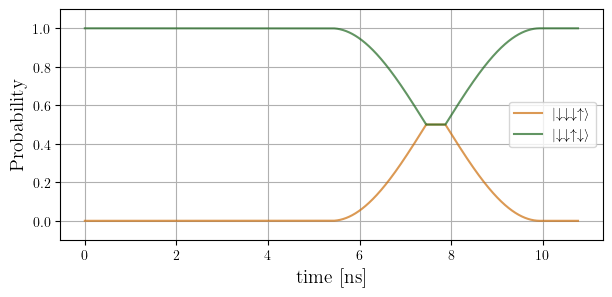

In [50]:

#self.ket_dru_0 = self.CZ(self.ket_dru_0, [], q_obj = [0,1])
#self.ket_dru_0 = self.CZ(self.ket_dru_0, [], q_obj = [2,3])

from qutip import tensor
#self.ket_dru_0 = self.CZ(self.ket_dru_0, [], q_obj = [1,2], tf_expectt =False)
#self.ket_dru_0 = self.CZ_4(self.ket_dru_0, q_obj=[0,3], tf_expect=False)


# 4 binario
ket_0 = tensor(basis(2, 0),basis(2, 0), basis(2, 1), basis(2, 0))

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,n_points_pulse_2Qbits=500,
                                     N_qubits = 4,
                                    tf_noise = False, noise_std = 0.0019,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c, save_time_values=True)

ket_dru_0 = dru_circuit.CZ(ket_0, [], q_obj = [0,1])
ket_dru_0 = dru_circuit.CZ(ket_dru_0, [], q_obj = [2,3])



states_4q = []
for i in range(16):
    estado_base = np.zeros((1,16))
    estado_base[0][i] = 1
    states_4q.append(estado_base)


time, m = measure_quantum_states(dru_circuit, states_4q)



# Lista de flechas para los estados base de 4 qubits
bases_strings = [
    [r"\downarrow", r"\downarrow", r"\downarrow", r"\downarrow"],
    [r"\downarrow", r"\downarrow", r"\downarrow", r"\uparrow"],
    [r"\downarrow", r"\downarrow", r"\uparrow", r"\downarrow"],
    [r"\downarrow", r"\downarrow", r"\uparrow", r"\uparrow"],
    [r"\downarrow", r"\uparrow", r"\downarrow", r"\downarrow"],
    [r"\downarrow", r"\uparrow", r"\downarrow", r"\uparrow"],
    [r"\downarrow", r"\uparrow", r"\uparrow", r"\downarrow"],
    [r"\downarrow", r"\uparrow", r"\uparrow", r"\uparrow"],
    [r"\uparrow", r"\downarrow", r"\downarrow", r"\downarrow"],
    [r"\uparrow", r"\downarrow", r"\downarrow", r"\uparrow"],
    [r"\uparrow", r"\downarrow", r"\uparrow", r"\downarrow"],
    [r"\uparrow", r"\downarrow", r"\uparrow", r"\uparrow"],
    [r"\uparrow", r"\uparrow", r"\downarrow", r"\downarrow"],
    [r"\uparrow", r"\uparrow", r"\downarrow", r"\uparrow"],
    [r"\uparrow", r"\uparrow", r"\uparrow", r"\downarrow"],
    [r"\uparrow", r"\uparrow", r"\uparrow", r"\uparrow"]
]

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
for i in range(16):
    if any(m[i]):
        plot_measure_continuous(ax, time, m[i], i, bases_strings[i])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_4CZ_V1_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()



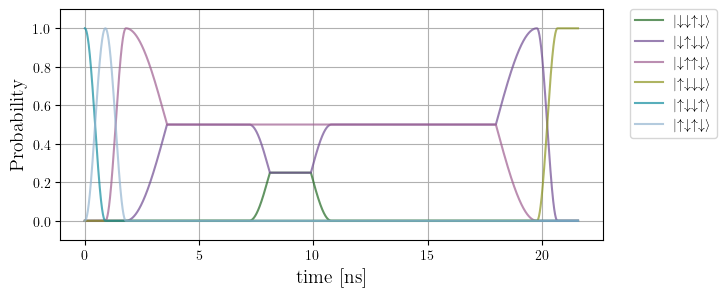

In [55]:
from qutip import tensor



# 4 binario
ket_0 = tensor(basis(2, 1),basis(2, 0), basis(2, 0), basis(2, 1))

# Def procesador
T2c = 2.3e-8
T2start = 102e-8
T1c = calculate_T1(T2c, T2start)
dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000, n_points_pulse_2Qbits=500,
                                     N_qubits = 4,
                                    tf_noise = False, noise_std = 0.019,
                                    tf_quantum_noise = False, T1= T1c, T2 = T2c, save_time_values=True)



#ket_dru_0  = dru_circuit.CZ(ket_0, [], q_obj = [1,2], tf_expectt =False)
ket_dru_0 = dru_circuit.CNOT_4(ket_0 , q_obj=[0,3], tf_expect=False)

states_4q = []
for i in range(16):
    estado_base = np.zeros((1,16))
    estado_base[0][i] = 1
    states_4q.append(estado_base)


time, m = measure_quantum_states(dru_circuit, states_4q)

def detect_all_zeros(m_list):
    umbral = 1e-3
    check_list = [valor < umbral for valor in m_list]
    return all(check_list)

# plot measure:
fig, ax = plt.subplots(figsize=(7, 3))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True
for i in range(16):
    if detect_all_zeros(m[i])==False:
        plot_measure_continuous(ax, time, m[i], i, bases_strings[i])
ax.set_ylabel(rf'Probability', fontsize=14)
ax.set_xlabel(r'time [ns]', fontsize=14)
#ax.set_title(rf'Probability of state $\left| {i} \right\rangle$', fontsize=16)
ax.set_ylim(-0.1, 1.1)
# Colocar la leyenda fuera del gráfico
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.grid()
path_to_save_img = os.path.join("results_of_test","test_2","probability_4CNOT_V2_in_time_wo_noise.pdf")
plt.savefig(path_to_save_img , format='pdf', bbox_inches = 'tight')
plt.show()
